# Fingerprint-based similarity scores - switch to sparse scores!

## Challenge
Fixed-length fingerprints come with problem of bit collisions. This can be circumvented when using sparse vectors.

Data:

Compare multiple fingerprints on the "ms2 structures" dataset [Bushuiev 2024].

In [1]:
import os
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_unique_inchikey14.pickle"
compounds = pd.read_pickle(os.path.join(path_data, filename))
compounds.head()

,inchikey,inchi,smiles,spectrum_id
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862


In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [4]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

  0%|          | 0/37663 [00:00<?, ?it/s]

In [5]:
compounds["mass"] = masses
compounds.head()

,inchikey,inchi,smiles,spectrum_id,mass
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None,423.904
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None,324.383
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250,427.494
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357,280.327
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862,314.340


In [6]:
from utils import FingerprintGenerator, SparseFingerprintGenerator, compute_fingerprints
from metrics import ruzicka_similarity_matrix_sparse, jaccard_similarity_matrix_sparse

## Compute sparse fingerprints and scores

In [6]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints(
    compounds, fpgen, count=True, sparse=True
)

100%|███████████████████████████████████| 37663/37663 [00:07<00:00, 4798.03it/s]


In [7]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_sparse = compute_fingerprints(
    compounds, fpgen, count=True, sparse=True
)

100%|███████████████████████████████████| 37663/37663 [00:11<00:00, 3288.03it/s]


In [9]:
# this are now sparse fingerprints --> bits, counts
fingerprints_morgan3_sparse[0]

(array([ 102572415,  129728088,  305720181,  381947833,  394944906,
         413522179,  422715066,  616028266,  658782932,  677115002,
         692354742,  717512901,  773607102,  775789760,  788012513,
         817799547,  824061994,  829754261,  847961216,  864674487,
         864942730,  878067945,  951226070,  969309216,  994485099,
        1016841875, 1334400161, 1352399629, 1414538737, 1475579790,
        1510328189, 1840994228, 1945433893, 2012777389, 2041434490,
        2076190208, 2092489639, 2170404731, 2245384272, 2246340824,
        2246699815, 2246728737, 2353112200, 2373046754, 2376939177,
        2401128110, 2497300032, 2591452236, 2604440622, 2700749481,
        2730429987, 2762810942, 2896319167, 2920190289, 2944555726,
        2969019787, 2971320646, 2976033787, 3044392905, 3064879565,
        3162837314, 3217380708, 3218693969, 3315826729, 3440517169,
        3452535345, 3458774156, 3463091208, 3467262120, 3542456614,
        3585989115, 3599391724, 3740751157, 3770

In [8]:
%%time

similarities_morgan3_count_sparse = ruzicka_similarity_matrix_sparse(
    fingerprints_morgan3_sparse, fingerprints_morgan3_sparse)

CPU times: user 14min 27s, sys: 7.37 s, total: 14min 34s
Wall time: 31.5 s


## Import already computed scores (not sparse! for later comparison)

In [11]:
similarities_rdkit = np.load("similarities_tanimoto_rdkit_4096bits.npy")

In [9]:
similarities_morgan3_count = np.load("similarities_ruzicka_morgan3_4096bits.npy")

## Morgan-3 binary + Tanimoto

In [11]:
#similarities_morgan3 = np.load("similarities_tanimoto_morgan3_4096bits.npy")

## Morgan-9 count

In [28]:
#similarities_morgan9_count = np.load("similarities_ruzicka_morgan9_4096bits.npy")

## Now also try classic rdkit fingerprint

In [12]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fingerprints_rdkit = compute_fingerprints(
    compounds, fpgen, count=False, sparse=True
)

100%|████████████████████████████████████| 37663/37663 [00:41<00:00, 901.07it/s]


In [13]:
fingerprints_rdkit[0].shape

(1998,)

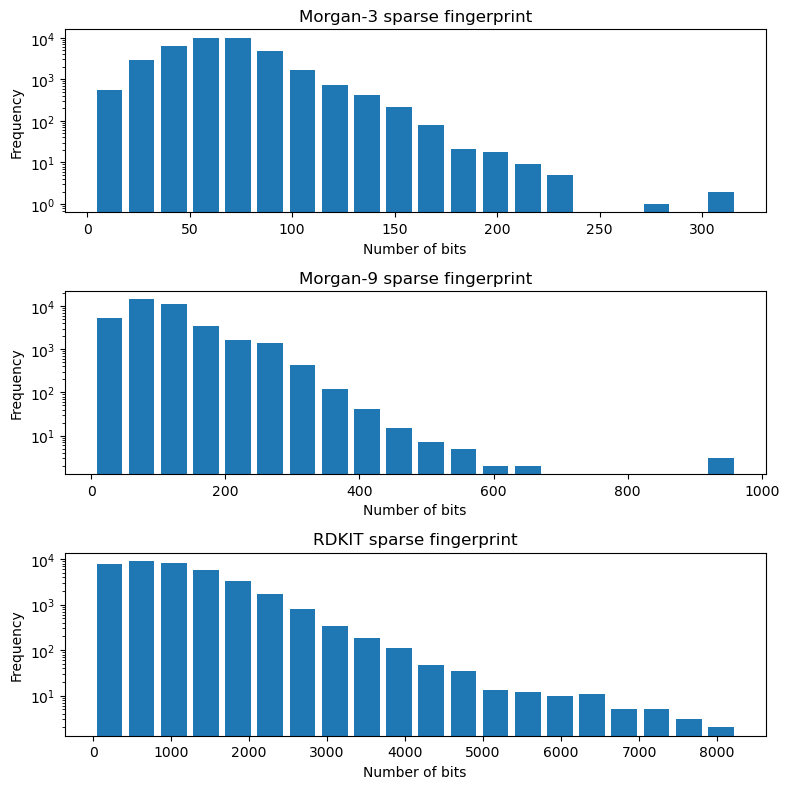

In [14]:
fingerprint_bits_morgan3 = np.array([x[0].shape[0] for x in fingerprints_morgan3_sparse])
fingerprint_bits_morgan9 = np.array([x[0].shape[0] for x in fingerprints_morgan9_sparse])
fingerprint_bits_rdkit = np.array([x.shape[0] for x in fingerprints_rdkit])



fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
ax1.hist(fingerprint_bits_morgan3, bins=20, rwidth=0.8)
ax2.hist(fingerprint_bits_morgan9, bins=20, rwidth=0.8)
ax3.hist(fingerprint_bits_rdkit, bins=20, rwidth=0.8)

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("Number of bits")
    ax.set_ylabel("Frequency")
    ax.set_yscale("log")


ax1.set_title("Morgan-3 sparse fingerprint")
ax2.set_title("Morgan-9 sparse fingerprint")
ax3.set_title("RDKIT sparse fingerprint")
fig.tight_layout()

plt.savefig("fig_bits_per_compound_histogram.pdf")
plt.savefig("fig_bits_per_compound_histogram.png", dpi=300)
plt.show()

### Compute Tanimoto Scores for Sparse Rdkit Fingerprints

In [15]:
%%time

similarities_rdkit_sparse = jaccard_similarity_matrix_sparse(
    fingerprints_rdkit, fingerprints_rdkit)

CPU times: user 2h 54min 49s, sys: 10.2 s, total: 2h 55min
Wall time: 6min 5s


In [16]:
np.save("similarities_tanimoto_rdkit_sparse.npy", similarities_rdkit_sparse)

In [7]:
similarities_rdkit_sparse = np.load("similarities_tanimoto_rdkit_sparse.npy")

## Adjust different score scales!

The two distributions above show that there is a huge discrepancy in how the scores are distributet. That also means: in how likely it is for a molecular pair to obtain a certain score!

**AIM**: bring all scores to the same overall distribution!?

### Adjust all to the same distribution --> use percentiles!

In [11]:
from utils import percentile_scores

In [41]:
%%time

scaled_similarities_rdkit_sparse = percentile_scores(similarities_rdkit_sparse)

CPU times: user 1min 53s, sys: 10.9 s, total: 2min 4s
Wall time: 2min 4s


In [ ]:
%%time

scaled_similarities_morgan3_count_sparse = percentile_scores(similarities_morgan3_count_sparse)

In [152]:
np.save("scaled_similarities_tanimoto_rdkit_sparse.npy", scaled_similarities_rdkit_sparse.astype(np.float32))
#np.save("scaled_similarities_ruzicka_morgan3_sparse.npy", scaled_similarities_morgan3_count_sparse.astype(np.float32))
#np.save("scaled_similarities_ruzicka_morgan9_4096bits.npy", scaled_similarities_morgan9_count.astype(np.float32))
#np.save("scaled_similarities_tanimoto_map4_4096bits.npy", scaled_similarities_map4.astype(np.float32))

In [58]:
#np.save("scaled_similarities_tanimoto_rdkit_4096bits.npy", scaled_similarities_classic.astype(np.float32))
#np.save("scaled_similarities_tanimoto_morgan3_4096bits.npy", scaled_similarities_morgan3.astype(np.float32))
#np.save("scaled_similarities_ruzicka_morgan3_4096bits.npy", scaled_similarities_morgan3_count.astype(np.float32))
#np.save("scaled_similarities_ruzicka_morgan9_4096bits.npy", scaled_similarities_morgan9_count.astype(np.float32))
#np.save("scaled_similarities_tanimoto_map4_4096bits.npy", scaled_similarities_map4.astype(np.float32))

In [17]:
scaled_similarities_rdkit = np.load("scaled_similarities_tanimoto_rdkit_4096bits.npy")
#scaled_similarities_rdkit_sparse = np.load("scaled_similarities_tanimoto_rdkit_sparse.npy")
#scaled_similarities_morgan3 = np.load("scaled_similarities_tanimoto_morgan3_4096bits.npy")
#scaled_similarities_morgan3_count = np.load("scaled_similarities_ruzicka_morgan3_4096bits.npy")
#scaled_similarities_morgan9_count = np.load("scaled_similarities_ruzicka_morgan9_4096bits.npy")
#scaled_similarities_map4 = np.load("scaled_similarities_tanimoto_map4_4096bits.npy")

## Compare score vs. score using heatmap

## Direct Score Comparisons

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable


def heatmap_comparison(similarities1, similarities2, label1, label2, bins=50,
                       colormap="viridis", ignore_diagonal=True,
                       add_region_percentage=True, filename=None,
                      ):
    """
    Generates a heatmap comparison of two similarity matrices.
    
    Parameters:
    similarities1 (ndarray): First similarity matrix (NxN) with values in a comparable range.
    similarities2 (ndarray): Second similarity matrix (NxN) with values in a comparable range.
    label1 (str): Label for the x-axis.
    label2 (str): Label for the y-axis.
    bins (int, optional): Number of bins for the 2D histogram (default: 50).
    colormap (str, optional): Colormap used for visualization (default: "viridis").
    ignore_diagonal (bool, optional): If True, excludes the diagonal values (default: True).
    filename (str, optional): If provided, saves the heatmap to the specified file.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Select upper triangle indices to ignore diagonal if necessary
    n = similarities1.shape[0]
    mask_indices = np.triu_indices(n, k=1 if ignore_diagonal else 0)
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1[mask_indices], 
        similarities2[mask_indices], 
        bins=bins
    )
    
    # Plot the heatmap using imshow with a logarithmic color scale
    im = ax.imshow(
        hist.T, origin='lower', aspect='equal',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        cmap=colormap, norm=LogNorm(vmin=1, vmax=np.max(hist))
    )
    
    # Create an axis of the same height for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("Count")
    
    # Compute total count for percentage calculations
    total_count = len(mask_indices[0])
    
    # Add text annotations for each 5x5 section of bins
    step = bins // 5
    for i in range(0, bins, step):
        for j in range(0, bins, step):
            sub_matrix = hist[i:i+step, j:j+step]
            subsection_sum = np.sum(sub_matrix)
            
            if subsection_sum > 0 and add_region_percentage:
                # Compute the center of the bin for text placement
                x_center = (x_edges[i] + x_edges[min(i + step, bins - 1)]) / 2
                y_center = (y_edges[j] + y_edges[min(j + step, bins - 1)]) / 2
                
                # Add text annotation
                ax.text(
                    x_center, y_center, f"{(100 * subsection_sum / total_count):.2f}%",
                    color="white", ha="center", va="center", fontsize=6, zorder=2
                )
    
    # Configure grid, labels, and layout
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    plt.tight_layout()
    
    # Save plot if a filename is provided
    if filename:
        plt.savefig(filename)
    
    # Show the plot
    plt.show()

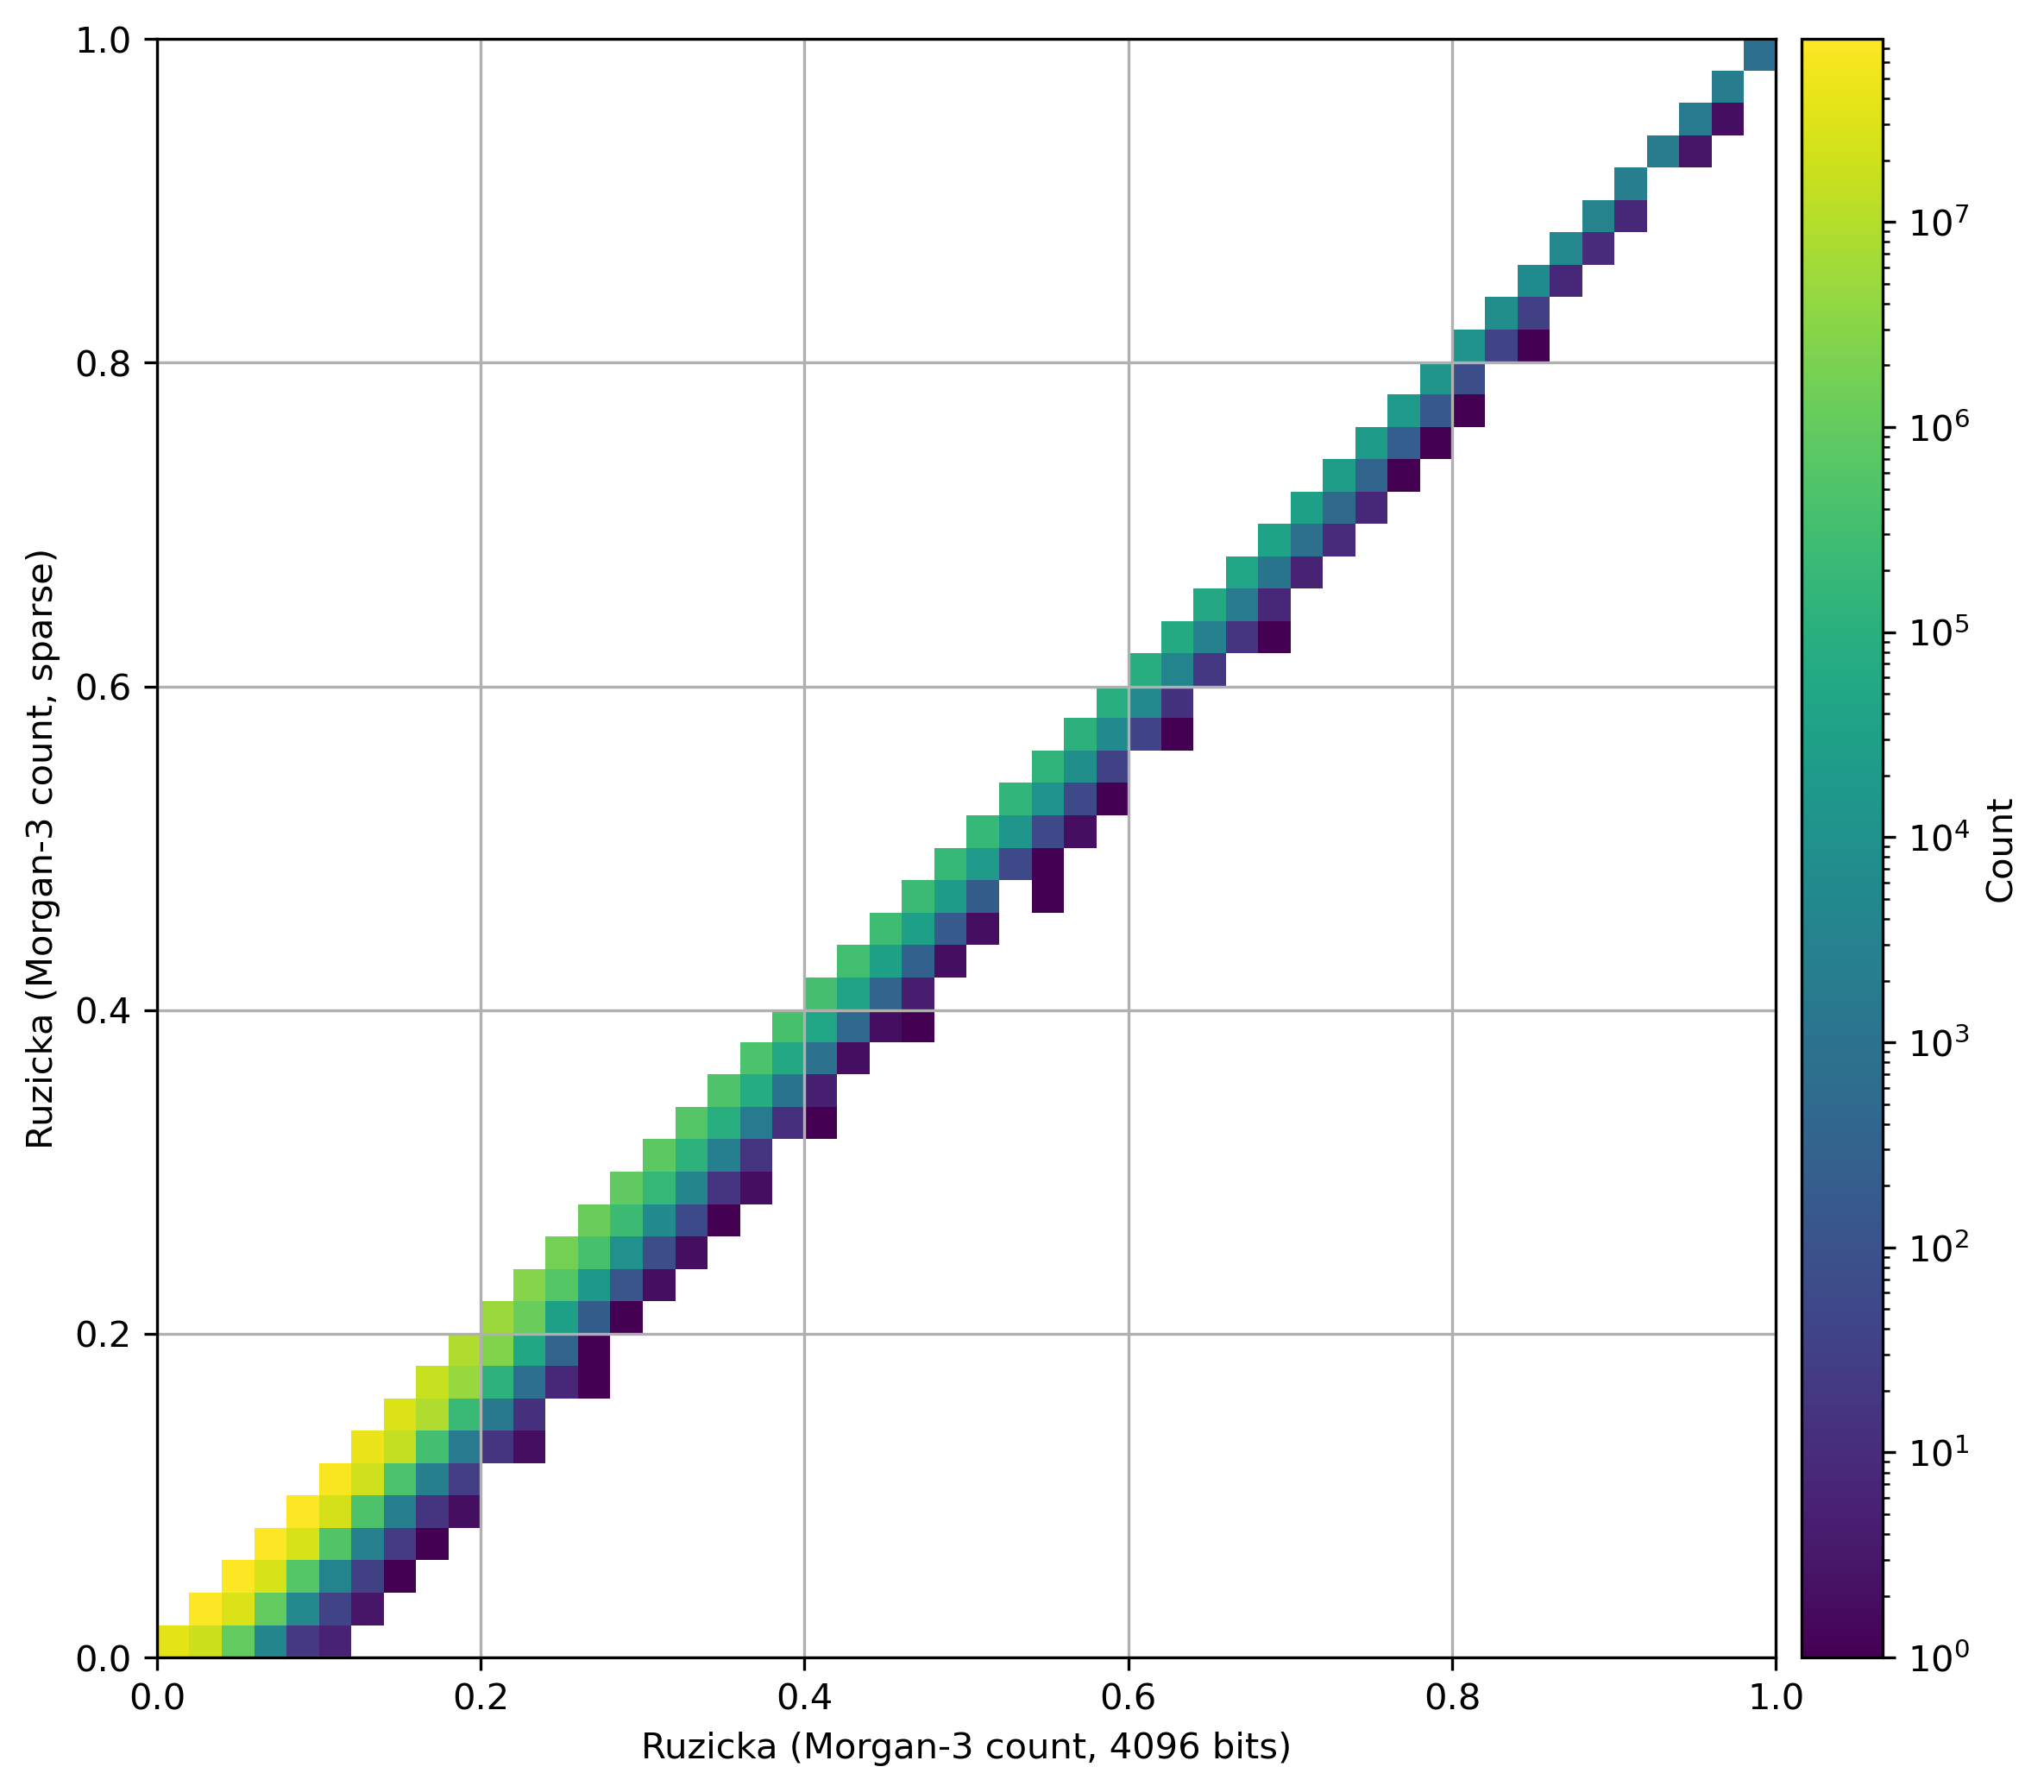

In [27]:
NBITS = 4096

heatmap_comparison(
    similarities_morgan3_count,
    similarities_morgan3_count_sparse,
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_ruzicka_morgan3_vs_sparse.png"
)

## Score Percentile Comparisons

In [ ]:
NBITS = 4096

heatmap_comparison(
    scaled_similarities_morgan3_count,
    scaled_similarities_morgan3_count_sparse,
    f"Percentiles - (Morgan-3 count, {NBITS} bits)",
    f"Percentiles - (Ruzicka (Morgan-3 count, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_scaled_ruzicka_morgan3_vs_sparse.png"
)

In [ ]:
from visualizations import heatmap_comparison_scaled_bins

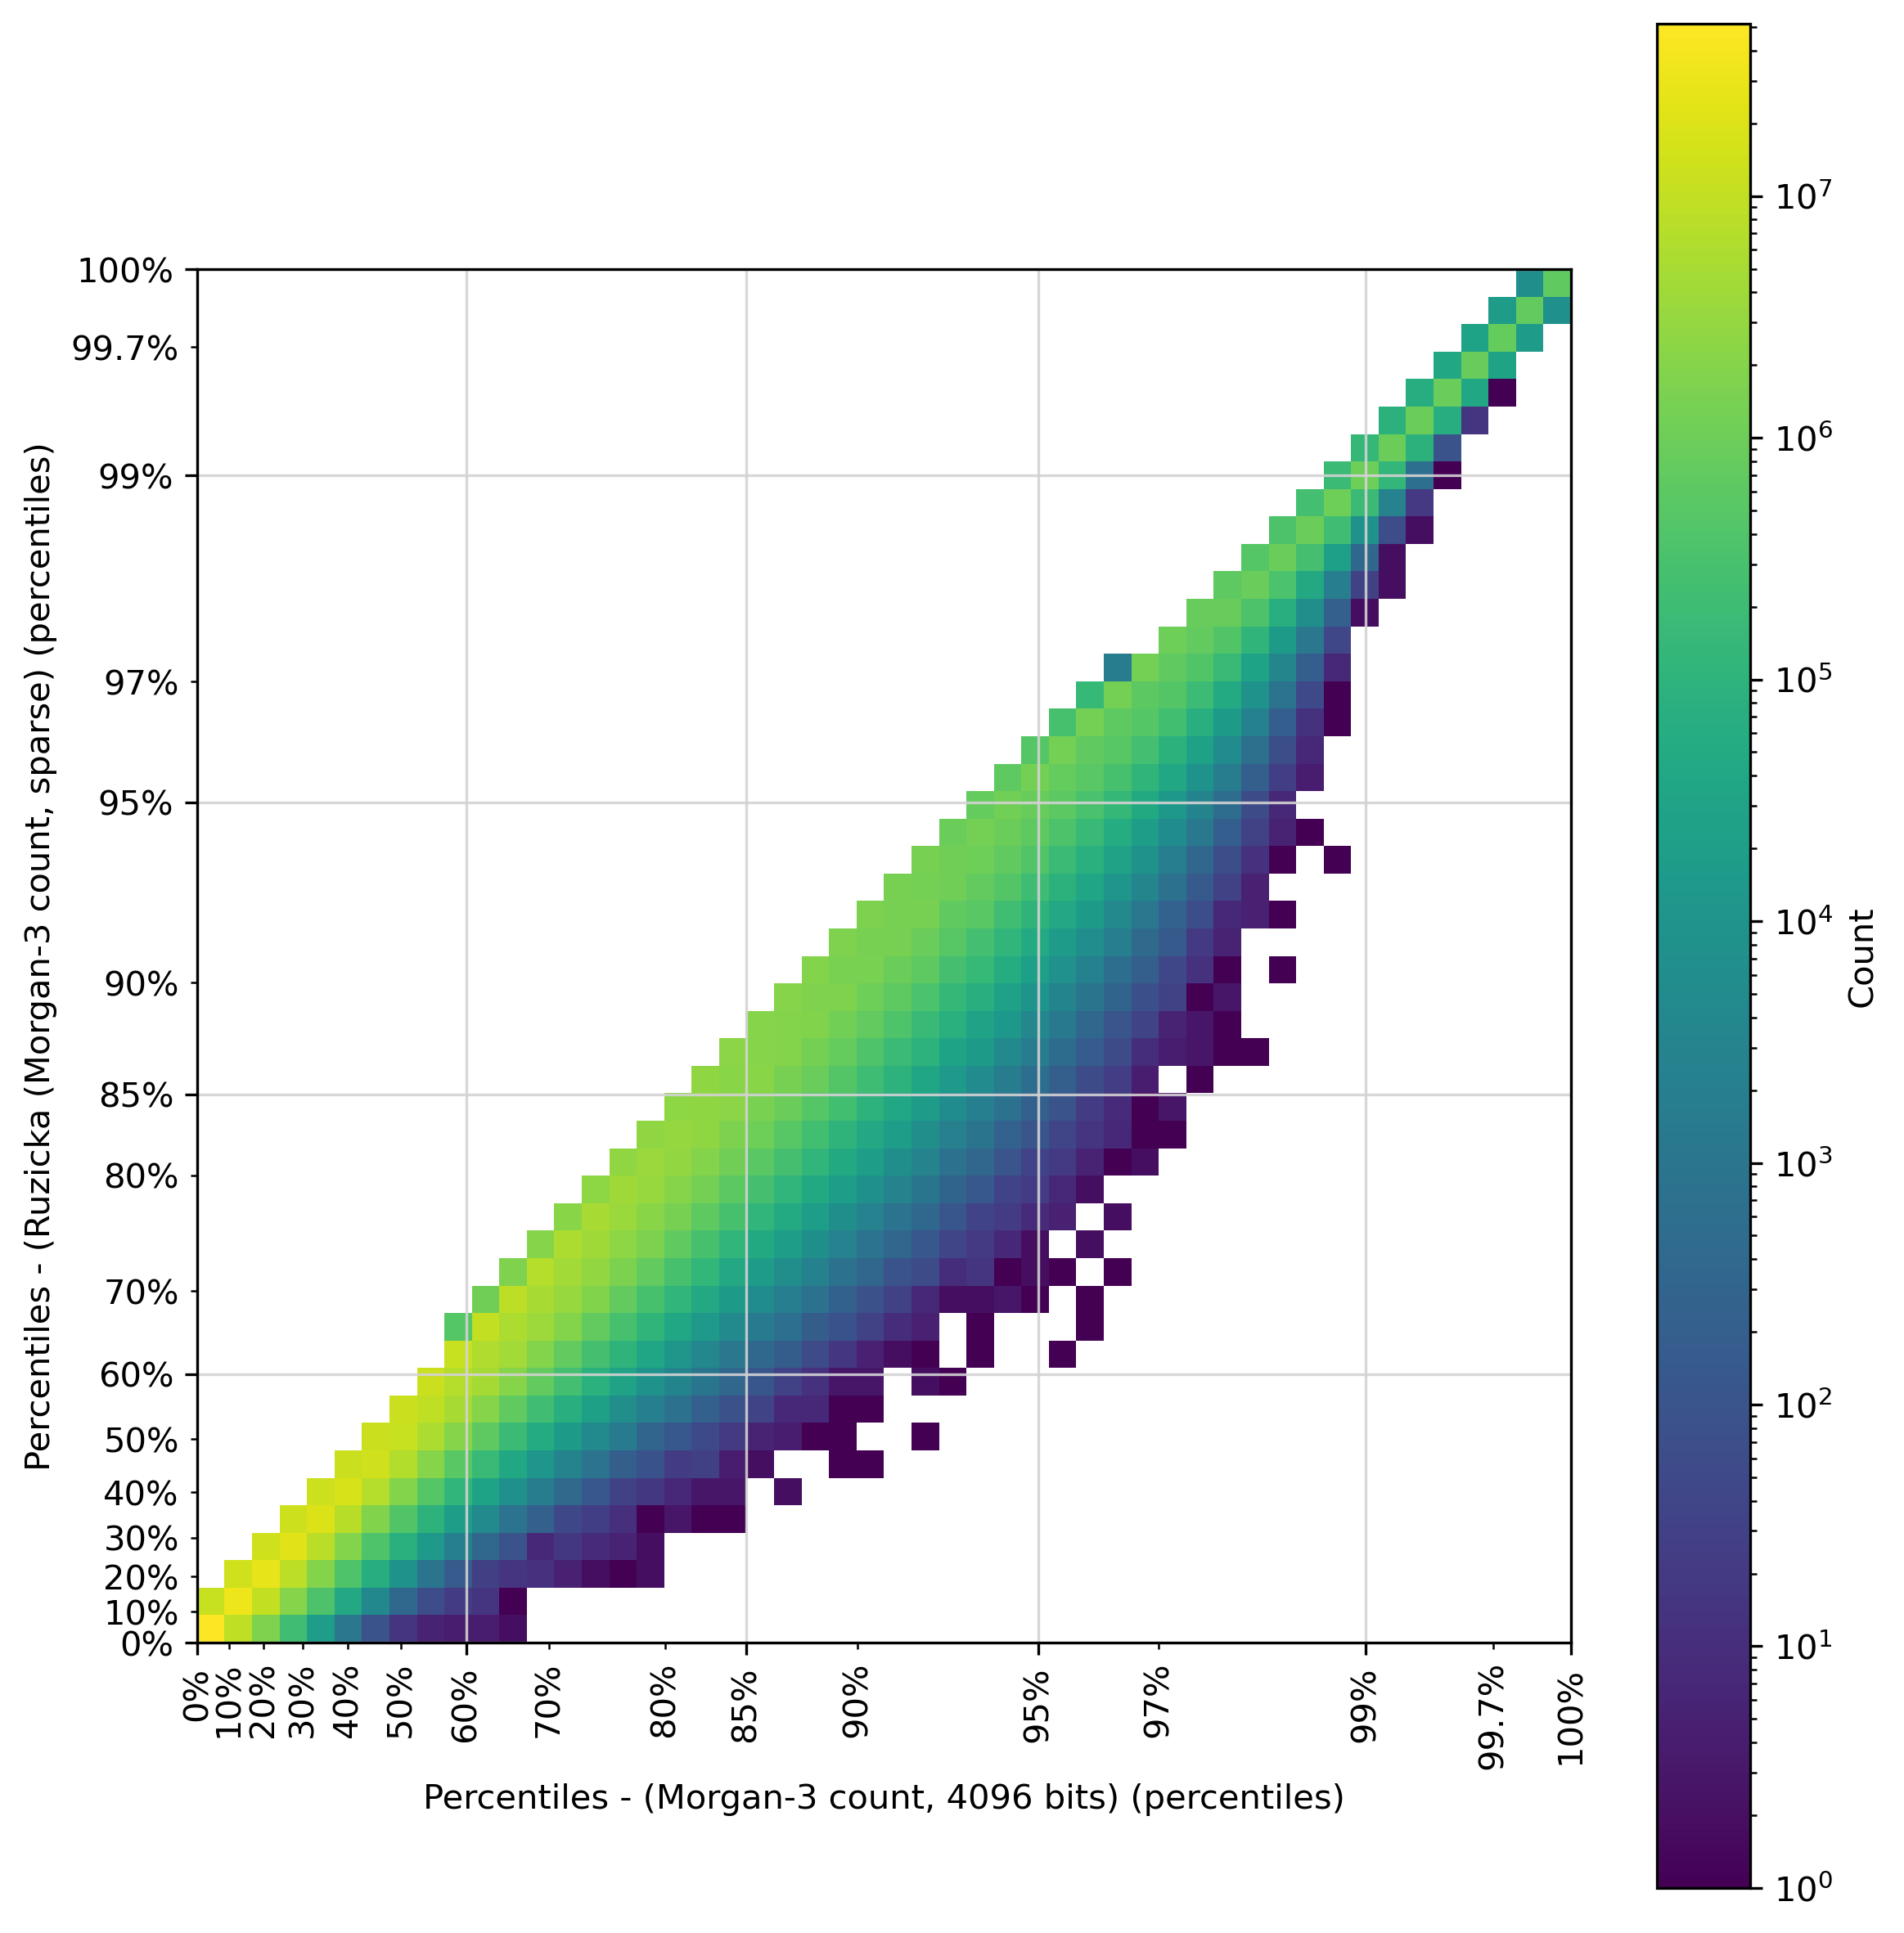

In [31]:
heatmap_comparison_scaled_bins(
    scaled_similarities_morgan3_count, #[:10_000, :10_000],
    scaled_similarities_morgan3_count_sparse, #[:10_000, :10_000],
    f"Percentiles - (Morgan-3 count, {NBITS} bits)",
    f"Percentiles - (Ruzicka (Morgan-3 count, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_scaled_ruzicka_morgan3_vs_sparse.png"
)

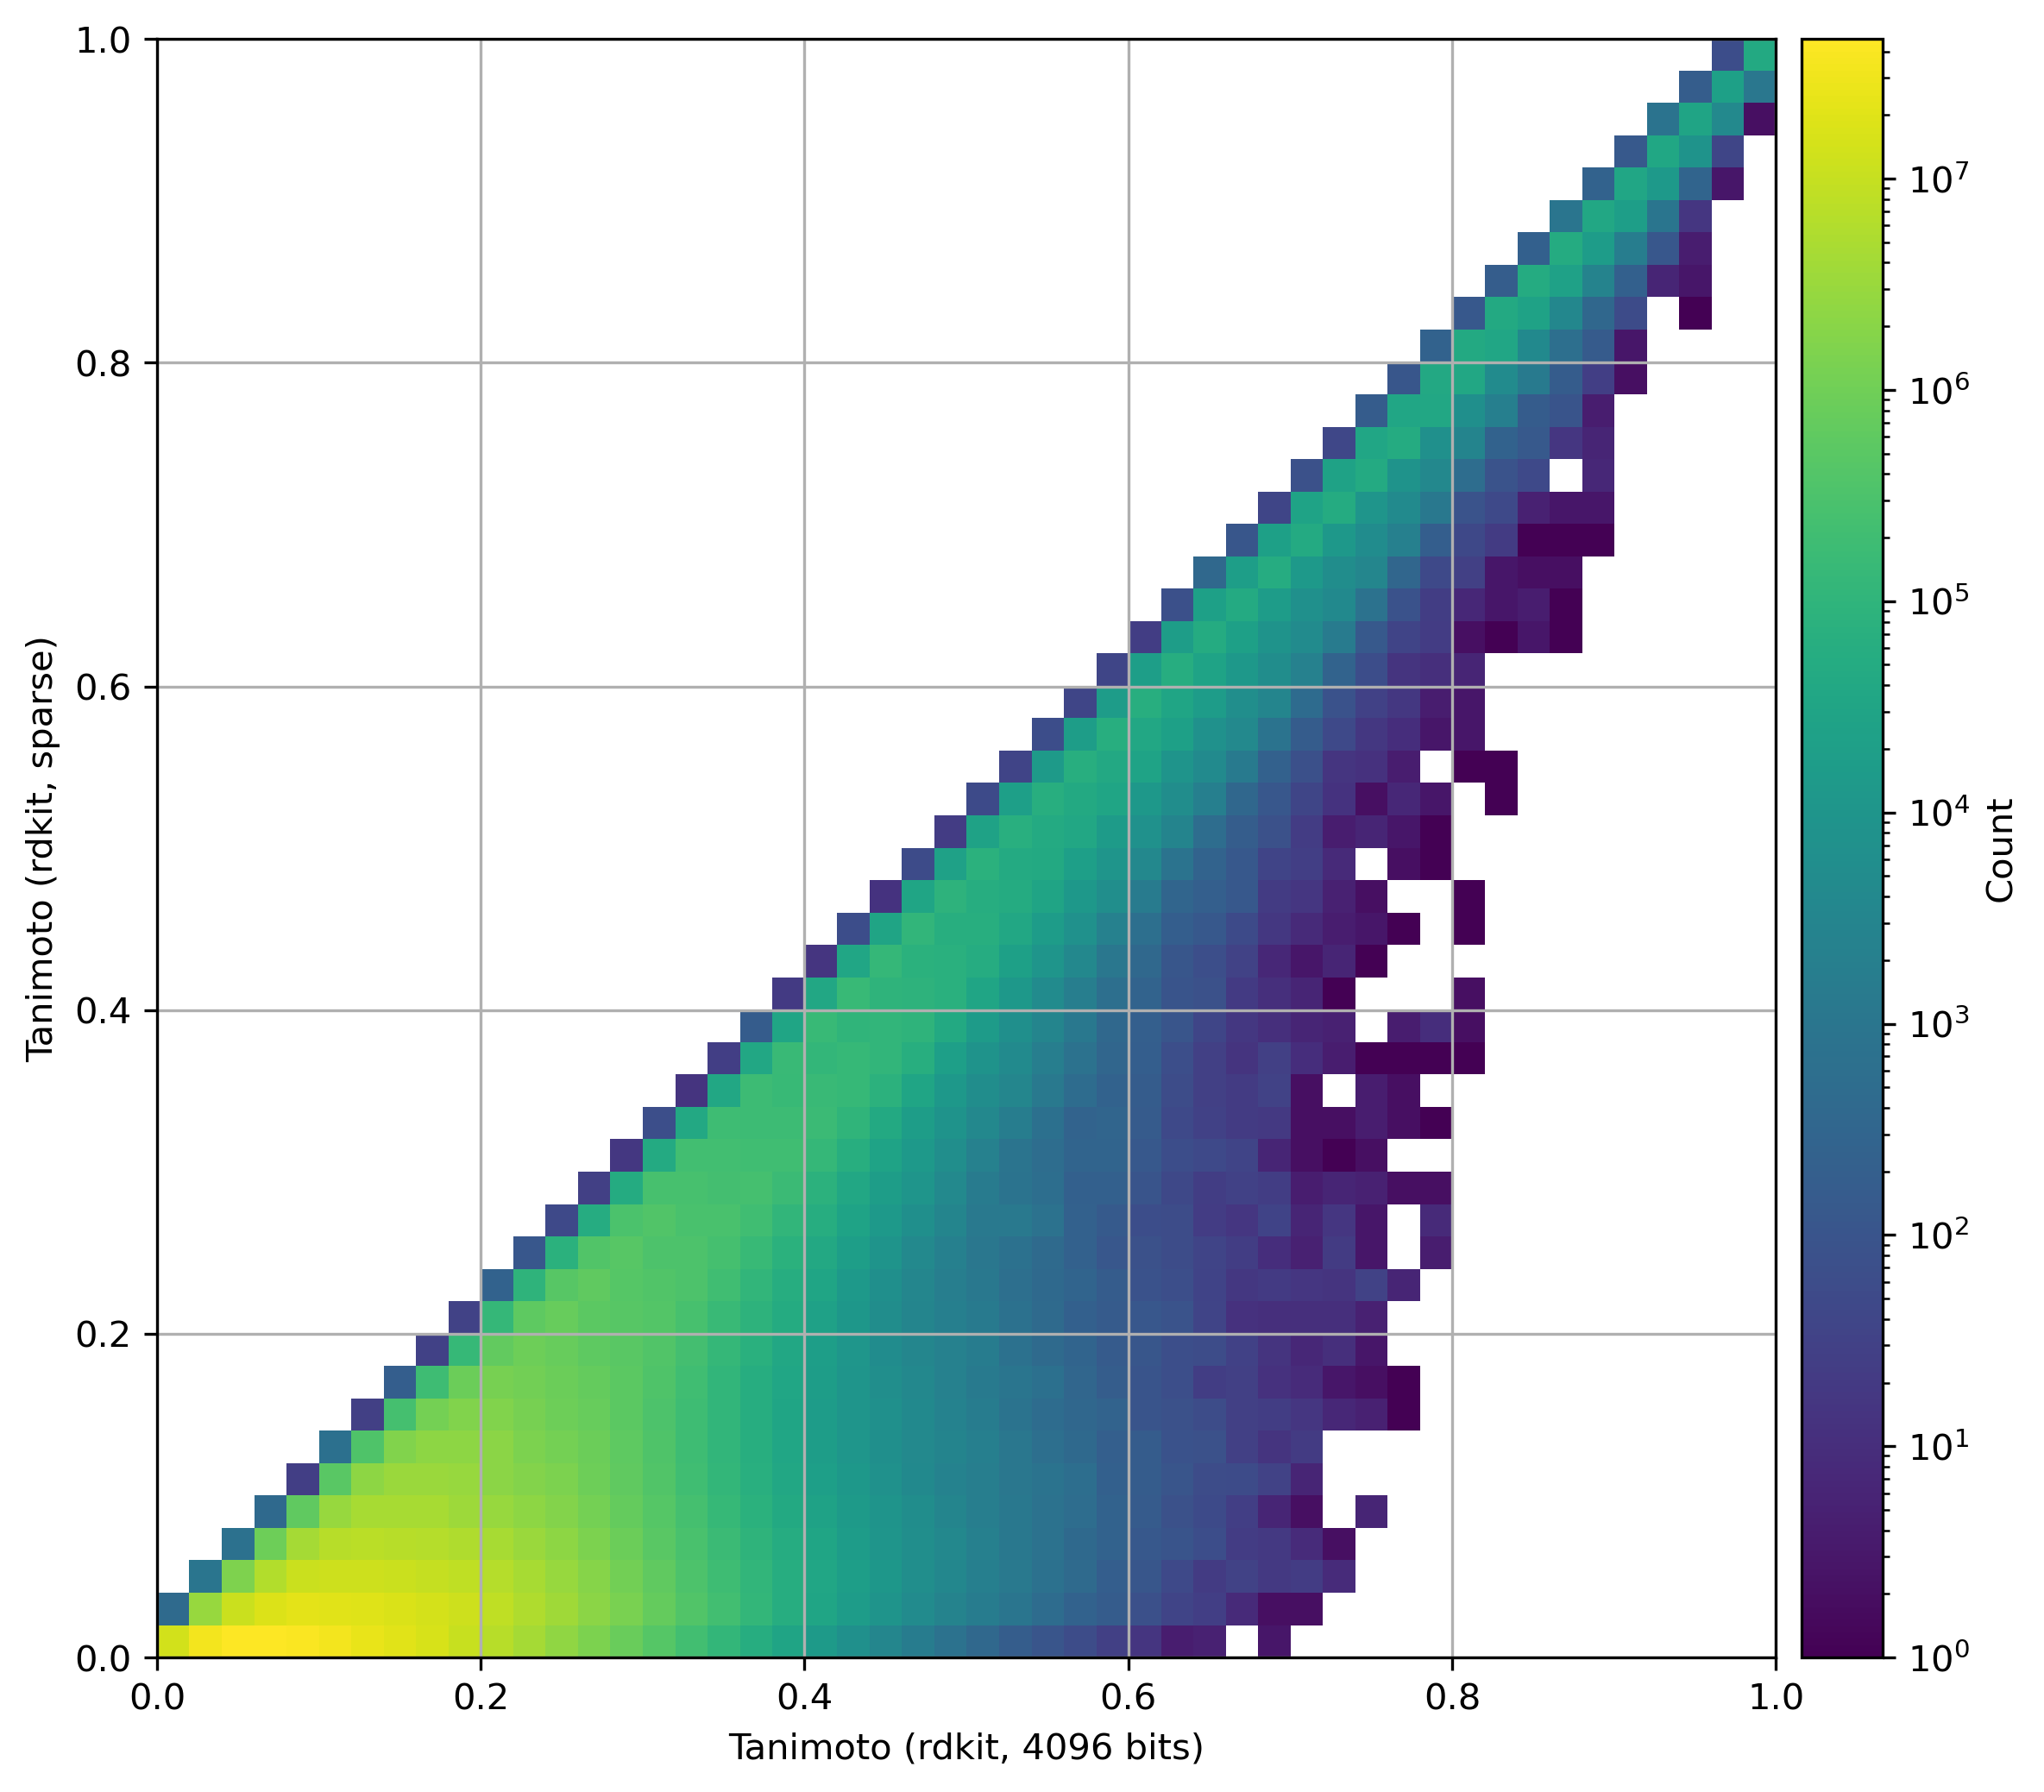

In [12]:
NBITS = 4096

heatmap_comparison(
    similarities_rdkit,
    similarities_rdkit_sparse,
    f"Tanimoto (rdkit, {NBITS} bits)",
    f"Tanimoto (rdkit, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_tanimoto_rdkit_vs_sparse.png"
)

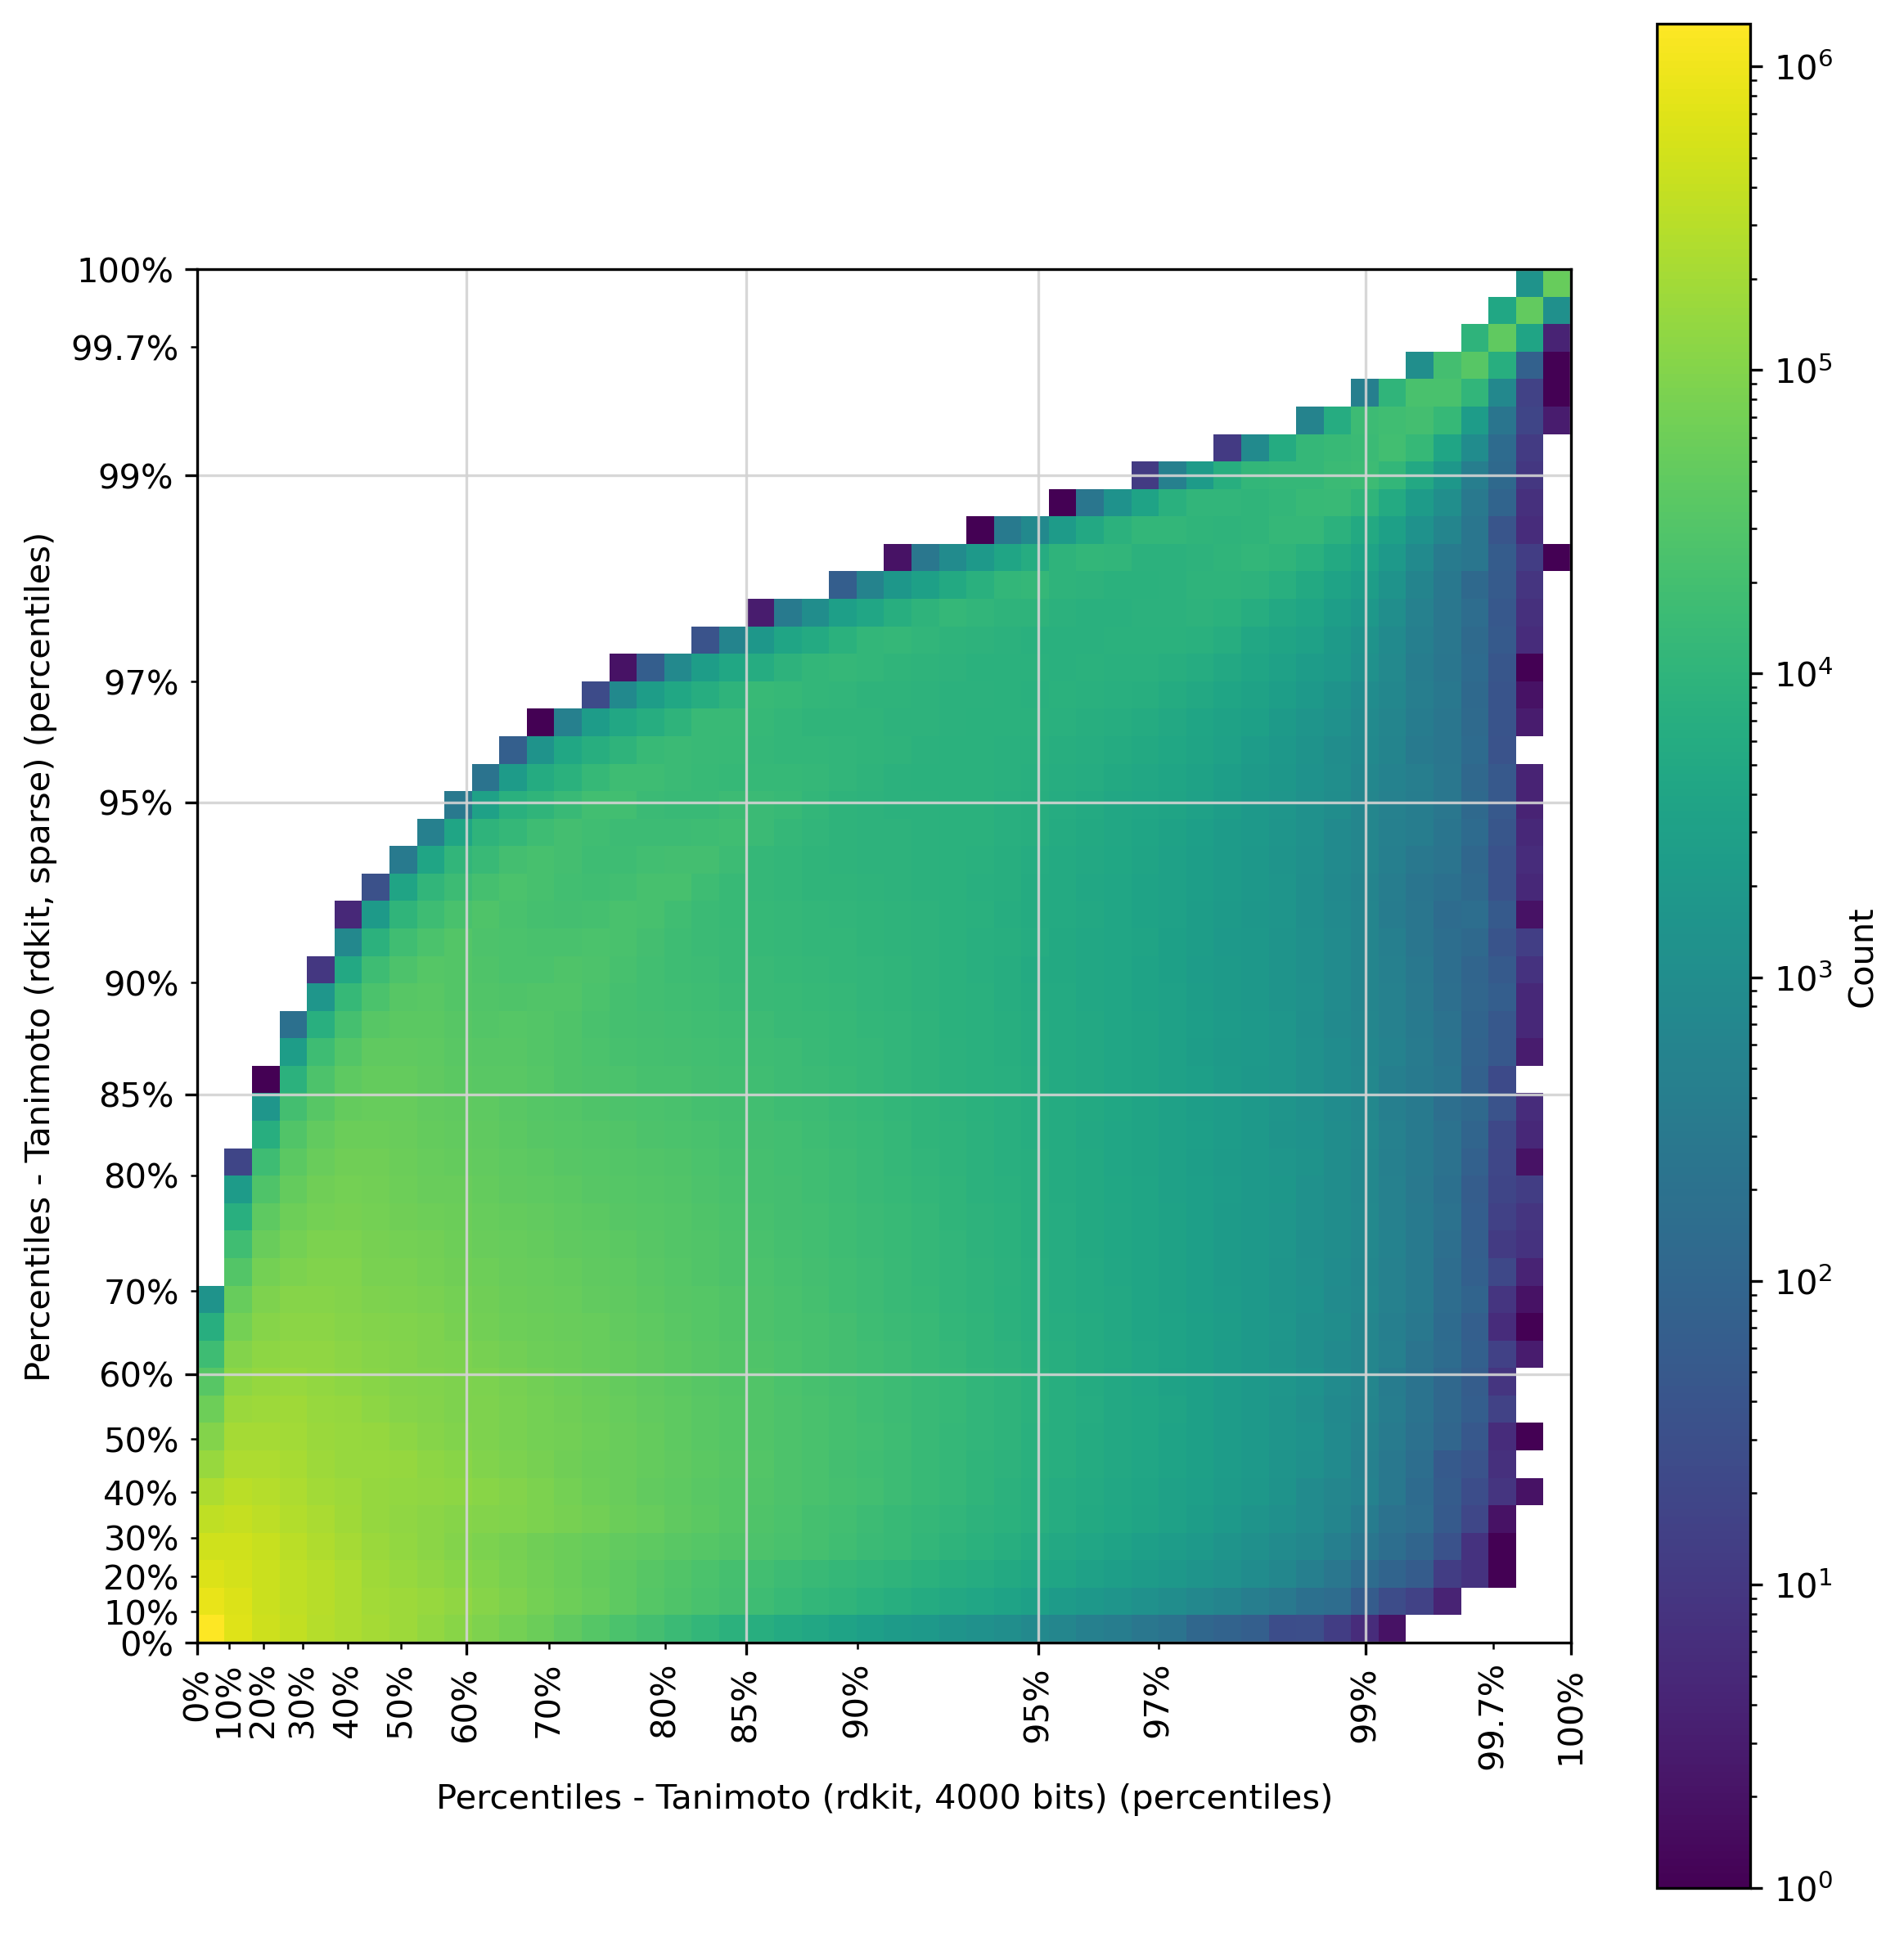

In [46]:
NBITS = 4000

heatmap_comparison_scaled_bins(
    scaled_similarities_rdkit:10_000, :10_000],
    scaled_similarities_rdkit_sparse[:10_000, :10_000],
    f"Percentiles - Tanimoto (rdkit, {NBITS} bits)",
    f"Percentiles - Tanimoto (rdkit, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_scaled_tanimoto_rdkit_vs_sparse.png"
)

# Find example pairs for illustration

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
import random


def select_pairs_from_ids(idx, n_pairs=10):
    pairs = list(zip(idx[0], idx[1]))
    
    # Step 1: Sort each pair so that (smaller, larger)
    sorted_pairs = {(min(a, b), max(a, b)) for a, b in pairs}
    
    # Step 2: Convert to a sorted list of unique pairs
    unique_pairs = list(sorted_pairs)
    
    # Step 3: Select only one per first ID
    selected_pairs = {}
    for a, b in unique_pairs:
        if a not in selected_pairs:
            selected_pairs[a] = (a, b)
        else:
            # Randomly decide whether to replace existing pair
            if random.random() > 0.5:
                selected_pairs[a] = (a, b)
    
    # Convert dictionary values back to a list
    final_pairs = list(selected_pairs.values())
    if len(final_pairs) < n_pairs:
        n_pairs = len(final_pairs)
    select_ids = np.random.choice(np.arange(len(final_pairs)), n_pairs, replace=False)
    return [final_pairs[i] for i in select_ids]


def show_pairs_in_grid(unique_pairs, ncols=2, figsize=(30, 18), filename=None):
    nrows = -(-len(unique_pairs) // ncols)  # Ceiling division to get number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, pair in enumerate(unique_pairs):
        id1, id2 = pair
        ax = axes[i]
        
        # Get SMILES and render molecules
        smiles1 = compounds.smiles[id1]
        smiles2 = compounds.smiles[id2]
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(800, 800), returnPNG=False)
        
        ax.imshow(img)
        ax.axis('off')
        
        # Get and display score summary below the molecules
        scores = get_score_summary(id1, id2)
        ax.set_title(f"Pair {i + 1}")
        ax.text(0.5, 0, scores, #.to_string(header=False), 
                transform=ax.transAxes, ha='center', fontsize=10, family='monospace')
    
    # Hide any unused subplots if number of pairs is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


## Find examples to illustrate regions - Morgan3 (sparse vs dense)

In [ ]:
def get_score_summary(id1, id2):
    output = f"Scaled Ruzicka (Morgan-3 count, sparse): {scaled_similarities_morgan3_count_sparse[id1, id2]:.4f}"\
    + f"(actual score: {similarities_morgan3_count[id1, id2]:.4f})\n"
    + f"Scaled Ruzicka (Morgan-3 count, 4096 bit): {scaled_similarities_morgan3_count[id1, id2]:.4f}"\
    + f"(actual score: {similarities_morgan3_count[id1, id2]:.4f})\n"
    return output

## Find examples to illustrate regions - RDKIT (sparse vs dense)

In [15]:
def get_score_summary(id1, id2):
    output = f"Scaled Tanimoto (RDKIT binary, sparse): {scaled_similarities_rdkit_sparse[id1, id2]:.4f}" \
    + f"(actual score: {similarities_rdkit_sparse[id1, id2]:.4f})\n"\
    + f"Scaled Tanimoto (RDKIT binary, 4096 bit): {scaled_similarities_rdkit[id1, id2]:.4f}" \
    + f"(actual score: {similarities_rdkit[id1, id2]:.4f})\n"
    return output

In [20]:
idx = np.where((scaled_similarities_rdkit > 99.8) \
               & (scaled_similarities_rdkit_sparse < 90) \
              )
idx[0].shape

(542,)

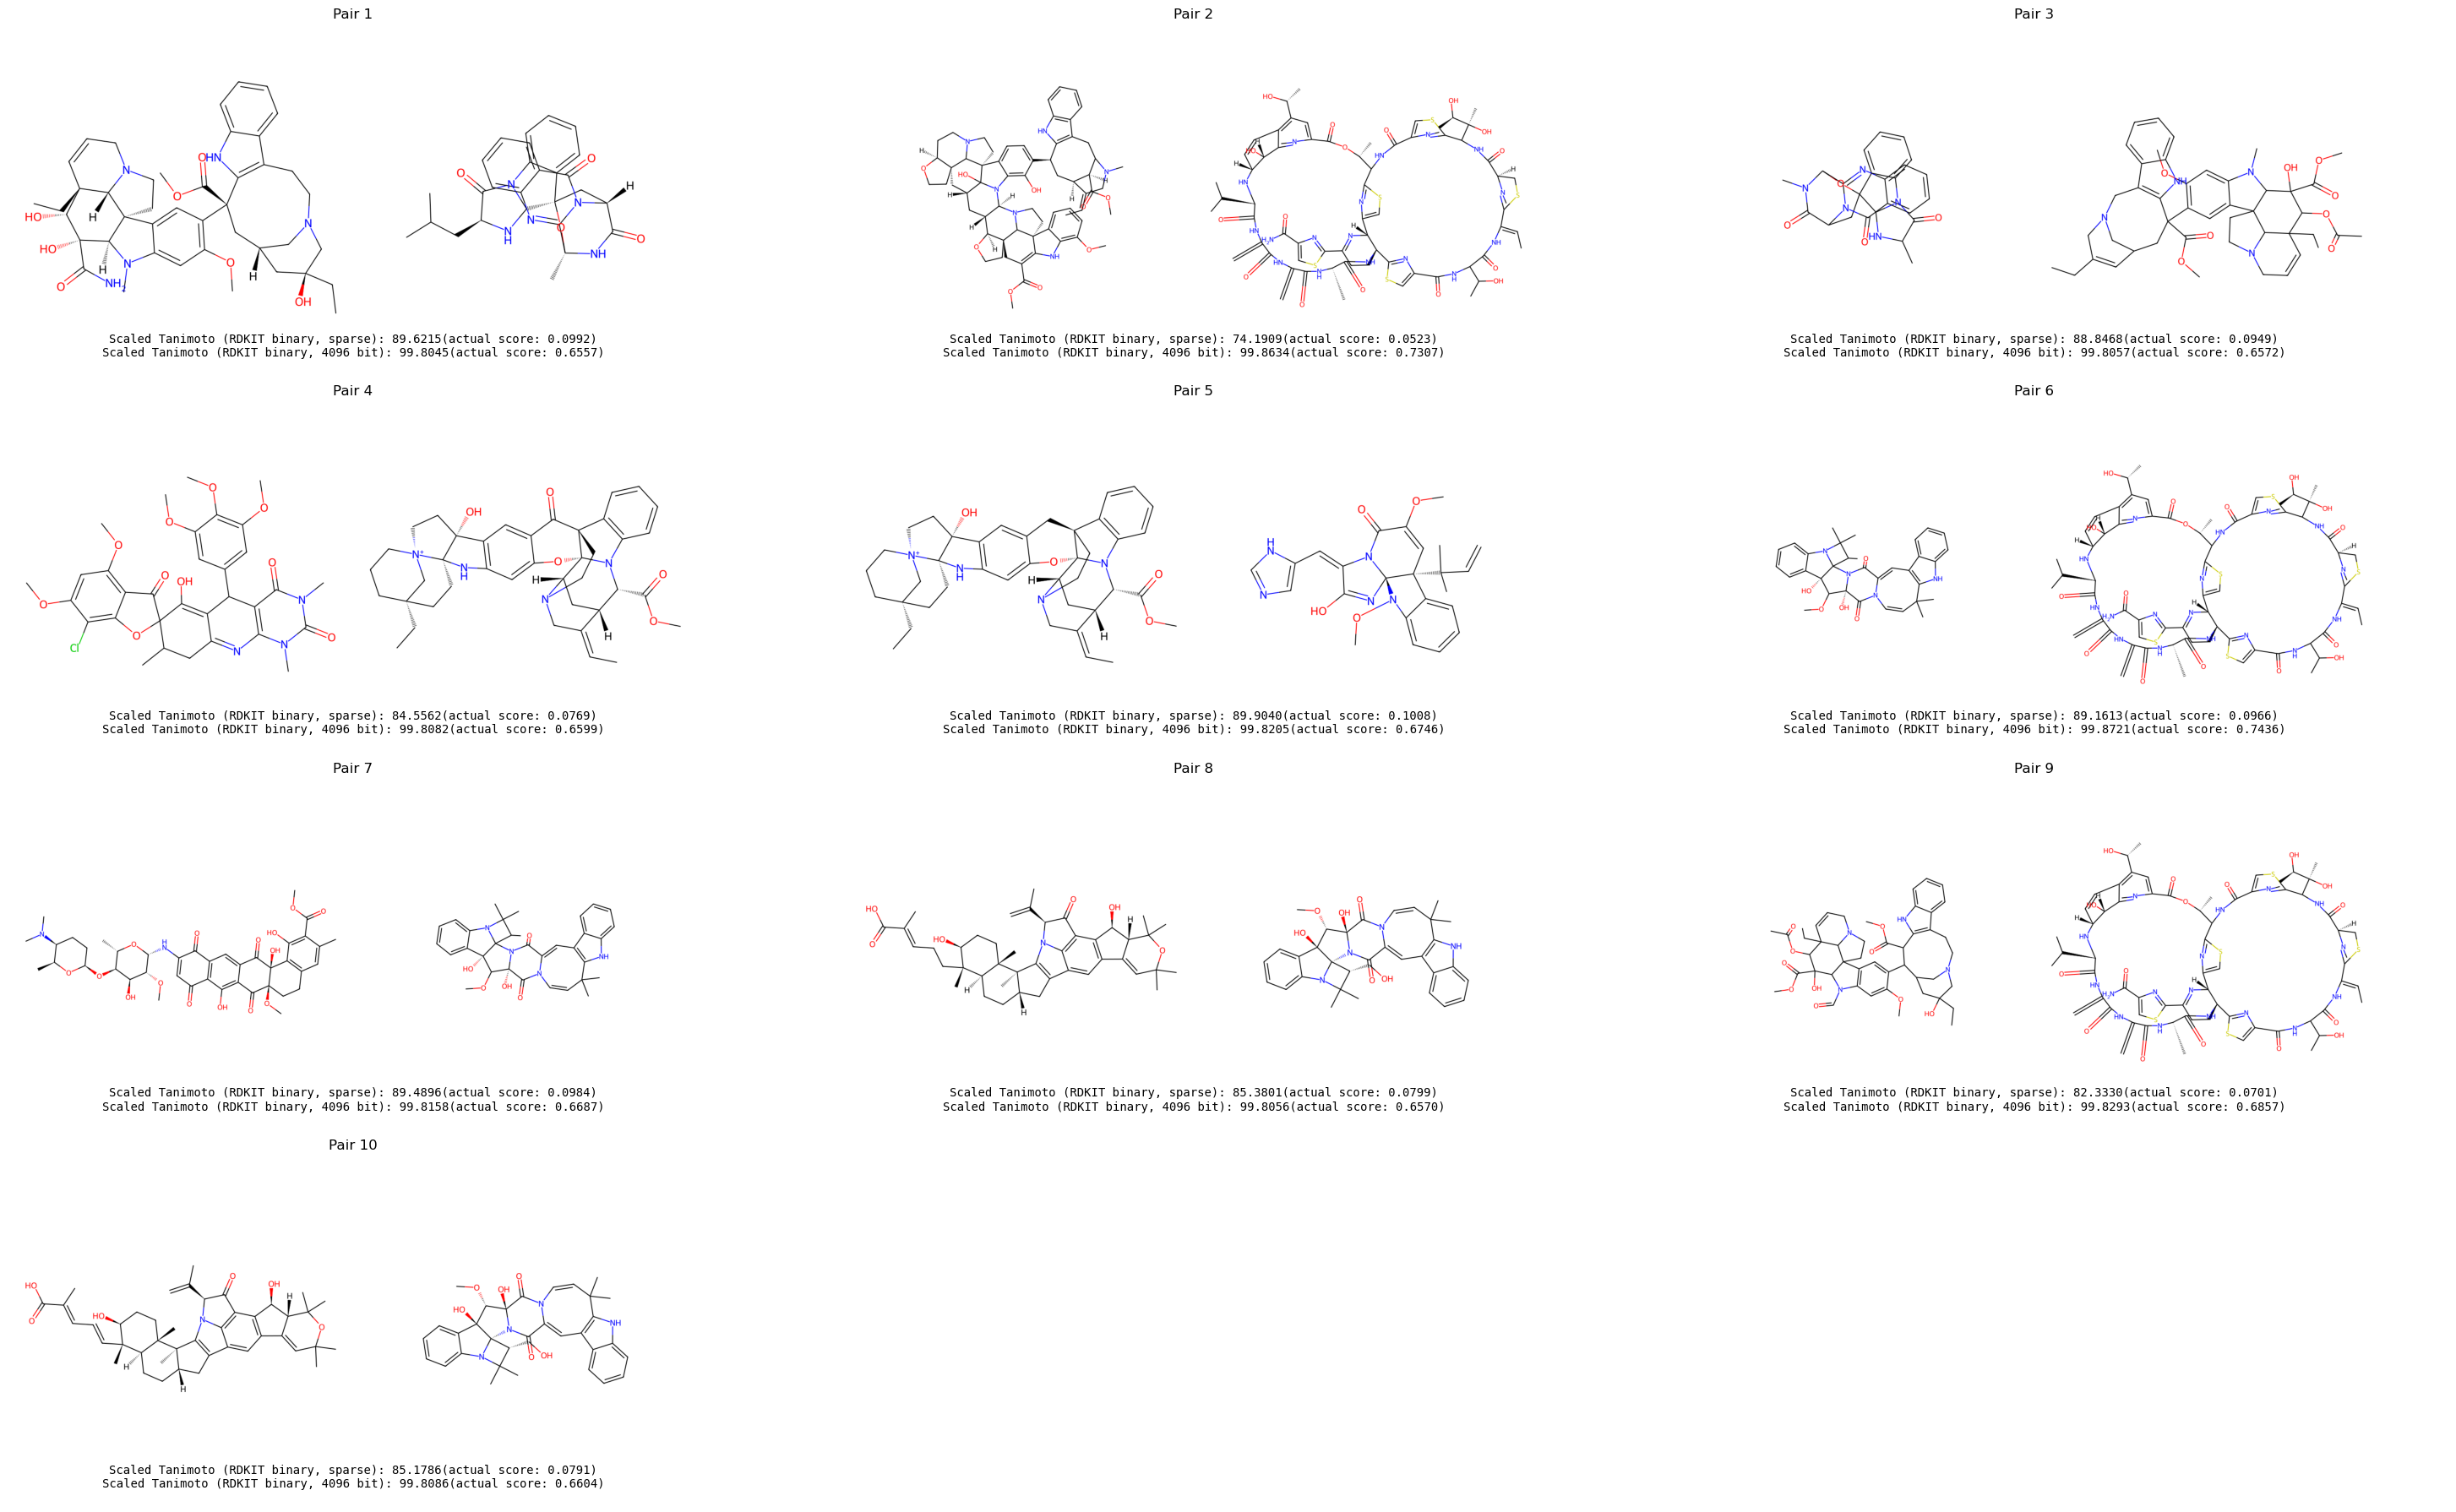

In [22]:
show_pairs_in_grid(select_pairs_from_ids(idx, 10), 3,
                   filename="examples_rdkit_vs_sparse_01.png"
                  )

In [30]:
idx = np.where((similarities_rdkit > 0.6) \
               & (similarities_rdkit_sparse < 0.1) \
              )
idx[0].shape

(2248,)

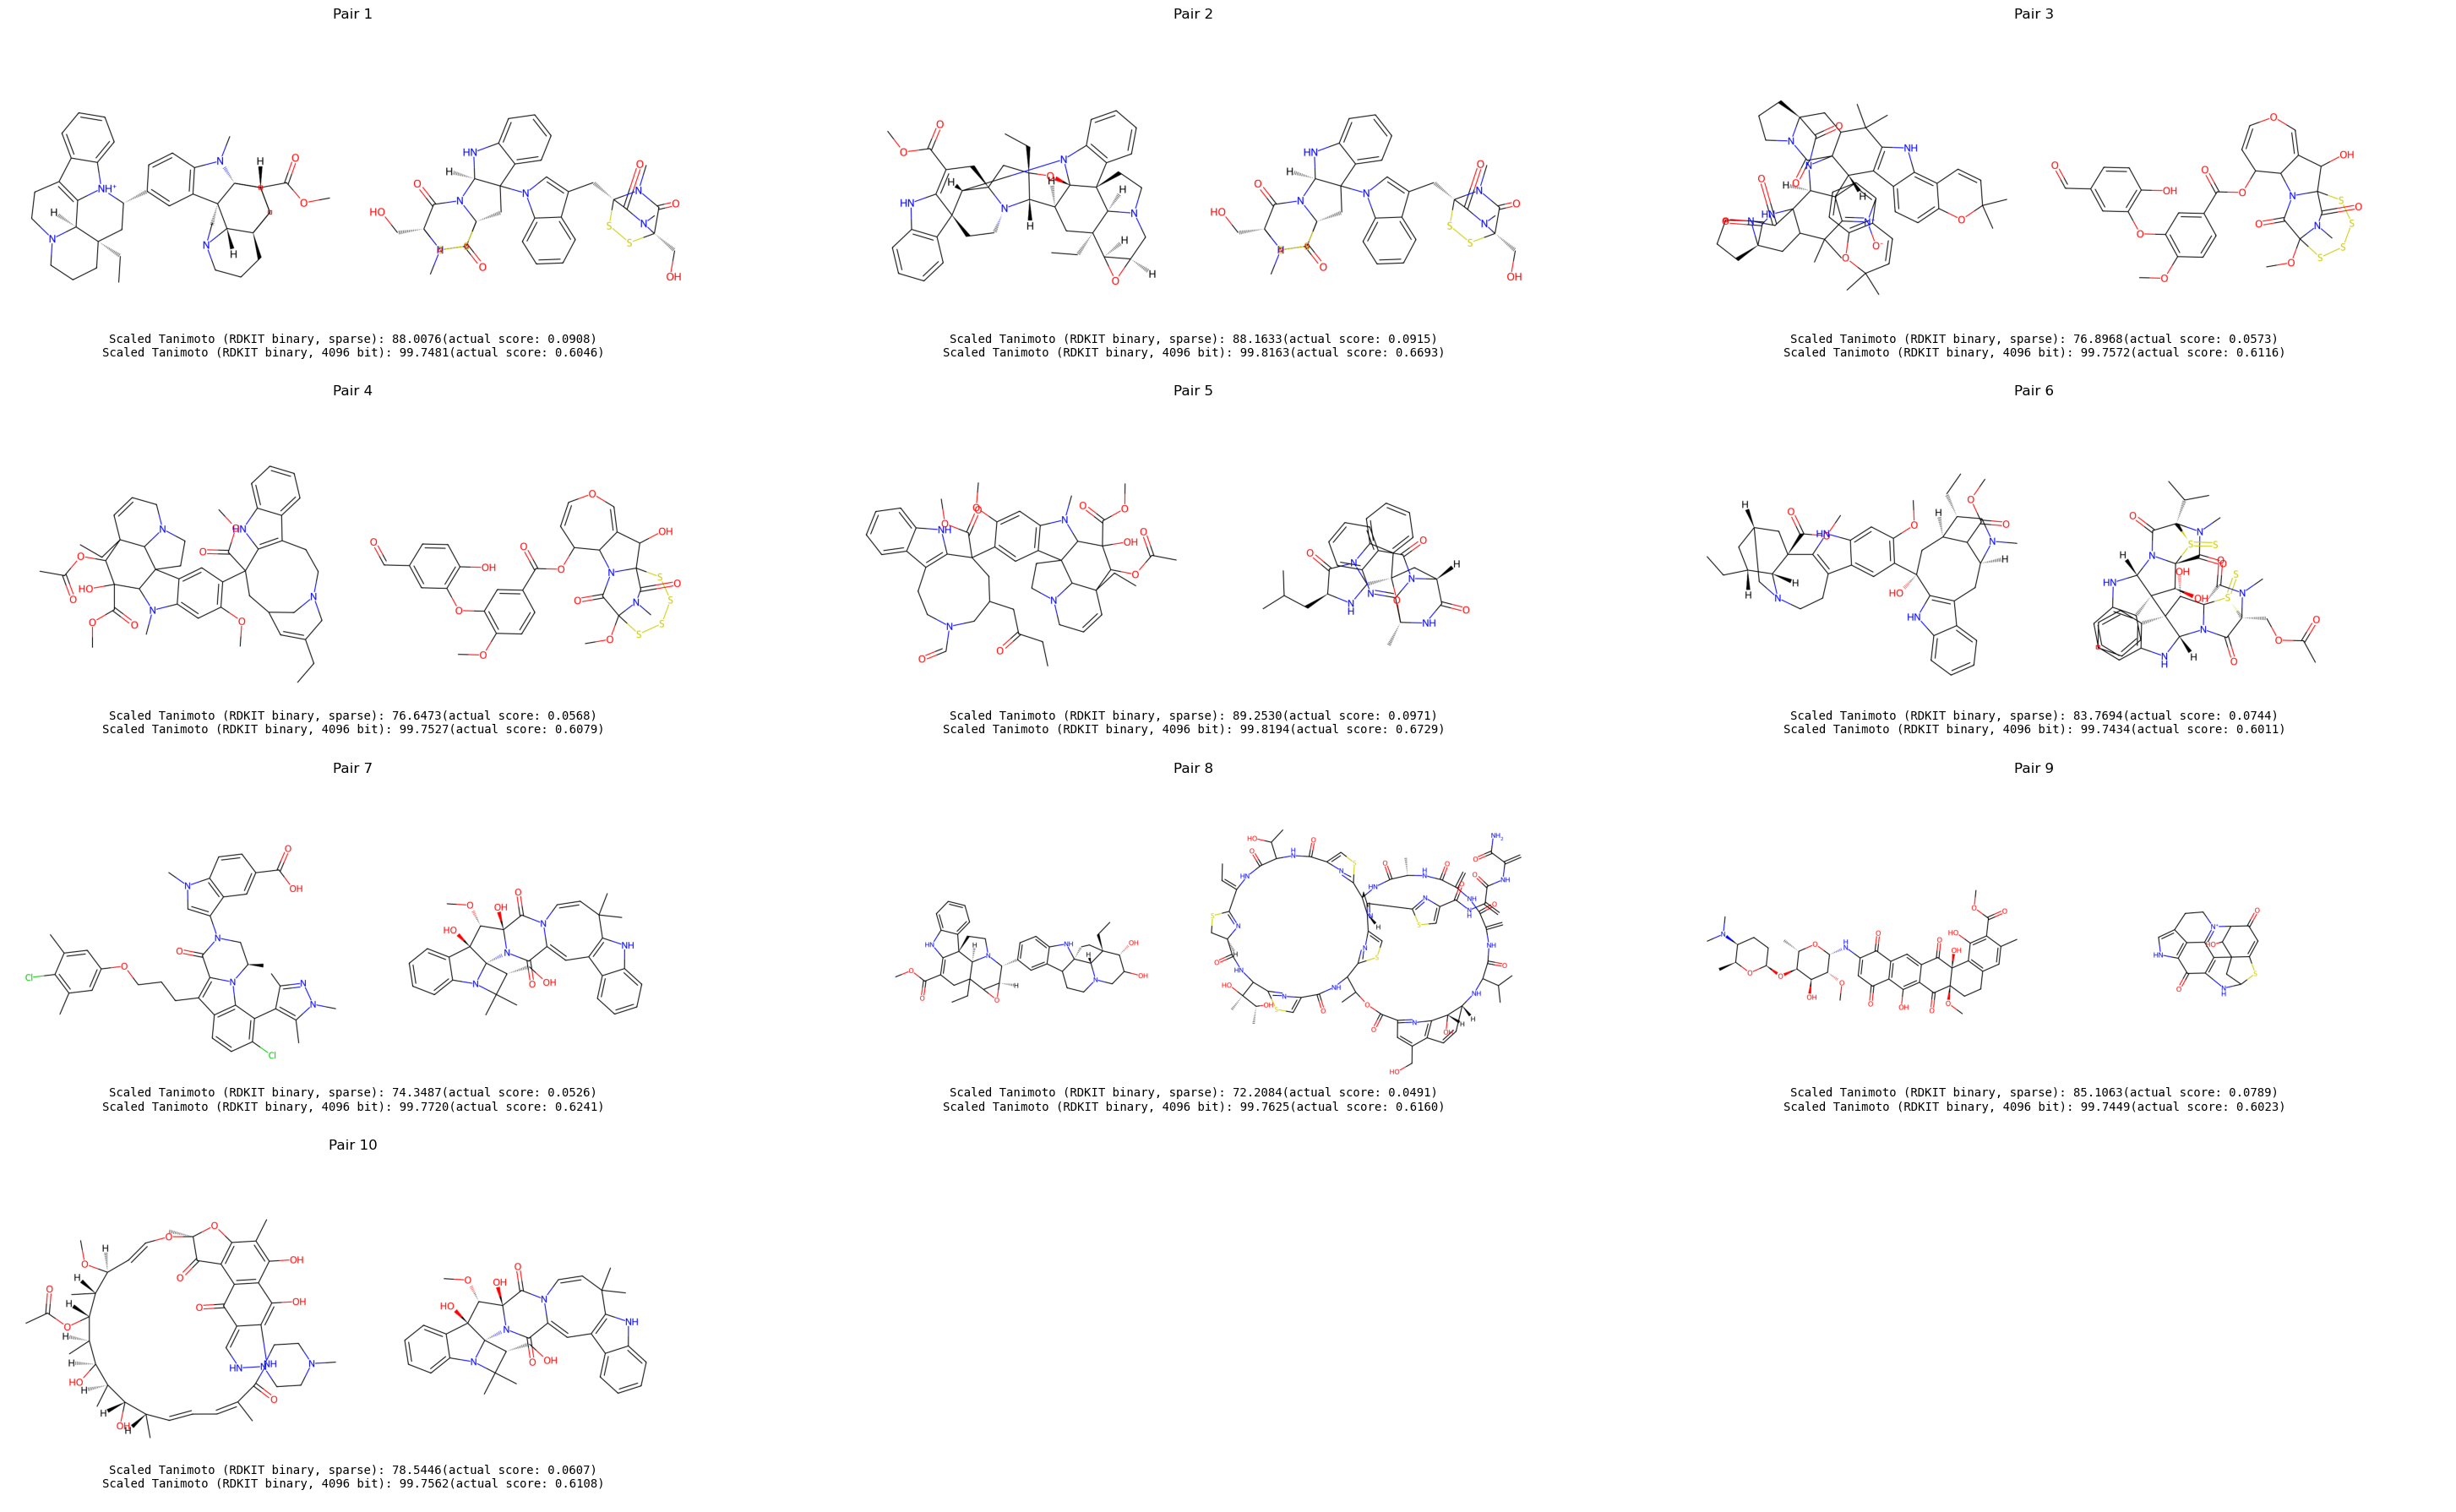

In [31]:
show_pairs_in_grid(select_pairs_from_ids(idx, 10), 3,
                   #filename="examples_rdkit_vs_sparse_02.png"
                  )

## Duplication Search using sparse fingerprints

In [131]:
import hashlib

def row_to_hash(row):
    """Convert a numpy array row to a hash string using SHA256."""
    row_bytes = row.tobytes()
    return hashlib.sha256(row_bytes).hexdigest()

def find_duplicates_with_hashing(arr):
    hash_dict = {}
    duplicates = []

    # Convert each row to a hash and store the row indices that have the same hash
    for idx, row in enumerate(arr):
        if isinstance(row, tuple):  # Sparse count fingerprints have the form (bits, counts)
            row_hash = row_to_hash(row[0]) + row_to_hash(row[1]) 
        else:
            row_hash = row_to_hash(row)
        if row_hash in hash_dict:
            hash_dict[row_hash].append(idx)
        else:
            hash_dict[row_hash] = [idx]

    # Collect all rows that have duplicate hashes
    for indices in hash_dict.values():
        if len(indices) > 1:
            duplicates.append(indices)
    
    return duplicates

def compute_compound_max_differences(masses):
    all_max_diffs = []
    min_mass = masses.min()
    max_mass = masses.max()
    for mass in masses:
        max_diff = max(mass - min_mass, max_mass - mass)
        all_max_diffs.append(max_diff)

    return np.array(all_max_diffs)

In [136]:
row = fingerprints_morgan3_sparse[0]
print(row_to_hash(row[0]))
print(row_to_hash(row[1]))

aa752a9e6ca66bd2b946b2977f4ea6fdfbd7ce180b9e5764168a6965f2b04535
aacf48c84e467dc29f3e5a6b4bd977374dd947f5630beb1d9a2af1569a9d9cc4


In [129]:
duplicates = find_duplicates_with_hashing(fingerprints_rdkit)

In [115]:
duplicates[:2]

[[7, 26581], [9, 15742]]

In [132]:
# Calculate statistics
duplicate_statistics = np.array([len(x) for x in duplicates])
duplicate_masses = [compounds.mass[i] for i in duplicates]
max_mass_differences = np.concatenate([compute_compound_max_differences(x) for x in duplicate_masses])

In [123]:
duplicate_statistics.sum()

np.int64(5407)

In [138]:
filename = "biostructures.csv"
compounds = pd.read_csv(os.path.join(path_data, "fleming_data", filename))
compounds = compounds.set_index("inchi_key_1")

exclude_inchikeys = [
    "XFXAGVXHBIDZJE", "KNSWLJFYTHGVGP", "MIUKAZMTBNWUDP",
    "ROYLRIQYTZJBAR", "KLHDFCUIIHOAIW", "SCMUSNCWPKDKKK", "CGCDOKHAYHELEG", "WONOLTWTXSUXQB", "JOHWNGGYGAVMGU",
    "LRWFHPLMQGPJCY", "KNSWNNXPAWSACI", "AXCBHWGTRNNXKG", "XHFXMNZYIKFCPN", "OSVXSBDYLRYLIG", "TVWHTOUAJSGEKT",
    "AOIWFGJNGXKHGL", "JHNJAVOZJQRGSH", "YXFJCDMOWXLUFT", "ZKIBBIKDPHAFLN", "LTDXHAFASXANOM", "FQFKTKUFHWNTBN", "XHVUVQAANZKEKF",
    "UTRRCWWJXMITGT", "RZPONWCINKBQNQ", "INDBPWPYJQZLTL", "VOGWKIGUWPCLMP",
    "YBNISKWFKJBFGP", "ITGROQVHGXJRIY", "CBHMIKMVVKYVSV", "JIVGQESTRBEXGT",
]

compounds = compounds.drop(exclude_inchikeys)

print(f"Number of unique compounds (according to Inchikey14): {pd.unique(compounds.index).shape[0]}.")

compounds.head()

Number of unique compounds (according to Inchikey14): 718067.


,smiles
inchi_key_1,
KFDYZSPFVRTLML,C1COCCN1C2=NC(=NC(=N2)NC3=CC(=C(C=C3)C=CC4=C(C...
HINREHSUCWWBNO,CCOC1=C(C=CC(=C1)C=NNC(=O)COC2=C(C=CC(=C2)C)C(...
XSJXTRKBEZABIM,CCOC1=C(C=CC(=C1)C=NNC(=O)COC2=C(C=CC(=C2)C(C)...
RGEDPHNWBSQUKZ,CC1=CC=CC=C1N2C(=NN=C2SCC(=O)NC3=CC(=C(C=C3)Cl...
RPFGFTBJBUHWDA,CC1=CC=CC=C1N2C(=NN=C2SCC(=O)NC3=C(C=CC=C3Cl)C...


In [139]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints(
    compounds, fpgen, count=True, sparse=True
)

 21%|███████████████                                                         | 150788/718067 [00:43<00:54, 10405.95it/s][12:33:18] WARNING: not removing hydrogen atom without neighbors
[12:33:18] WARNING: not removing hydrogen atom without neighbors
[12:33:18] WARNING: not removing hydrogen atom without neighbors
100%|█████████████████████████████████████████████████████████████████████████| 718067/718067 [02:39<00:00, 4502.82it/s]


In [154]:
fingerprints_morgan3_sparse[1]

(array([  93585016,  102492624,  194855659,  422715066,  445431883,
         498730307,  548743766,  573169829,  584823634,  589930590,
         708370251,  730049667,  788839801,  847336149,  847961216,
         864674487,  864942730,  941282395,  950023157,  951226070,
         994485099, 1013267280, 1016841875, 1081231276, 1135286194,
        1143528820, 1266193593, 1310068516, 1490549211, 1510328189,
        1517662977, 1571432276, 1595673428, 1714831564, 1761951119,
        1788699751, 1844294411, 2050509910, 2077658817, 2115476908,
        2132058917, 2180786472, 2245273601, 2245384272, 2246340824,
        2246699815, 2246703798, 2246728737, 2309124039, 2424973678,
        2458968089, 2492789883, 2594220197, 2650699036, 2677858541,
        2713535913, 2788540332, 2827868305, 2829714342, 2931695851,
        2931878080, 2956998777, 3011598321, 3056593145, 3058180405,
        3060172001, 3079735252, 3088822697, 3112905891, 3207567135,
        3217380708, 3218693969, 3315826729, 3347

In [140]:
name = "morgan3_count_sparse"

# Search fingerprint duplicated
duplicates = find_duplicates_with_hashing(fingerprints_morgan3_sparse)
duplicate_statistics = np.array([len(x) for x in duplicates])
with open(f"{name}_duplicates.pickle", "wb") as handle:
    pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

Total of 64885 compounds have duplicated fingerprints.
The largest cluster has 381 compounds with identical fingerprint.


In [141]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fingerprints_rdkit_sparse = compute_fingerprints(
    compounds, fpgen, count=False, sparse=True
)

 21%|███████████████▎                                                         | 150842/718067 [02:37<03:48, 2483.84it/s][12:38:25] WARNING: not removing hydrogen atom without neighbors
[12:38:25] WARNING: not removing hydrogen atom without neighbors
[12:38:25] WARNING: not removing hydrogen atom without neighbors
100%|██████████████████████████████████████████████████████████████████████████| 718067/718067 [21:51<00:00, 547.34it/s]


In [142]:
name = "rdkit_sparse"

# Search fingerprint duplicated
duplicates = find_duplicates_with_hashing(fingerprints_rdkit_sparse)
duplicate_statistics = np.array([len(x) for x in duplicates])
with open(f"{name}_duplicates.pickle", "wb") as handle:
    pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

Total of 127403 compounds have duplicated fingerprints.
The largest cluster has 14153 compounds with identical fingerprint.


In [150]:
files_experiments = [
    ("daylight", "RDKit fingerprint (4096 bits)"),
    ("rdkit_sparse", "RDKit fingerprint (sparse)"),
    #("daylight_1024", "RDKit fingerprint (1024 bits)"),
    #("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    #("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    #("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    #("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    #("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    #("morgan4_count", "Morgan-4 count fingerprint (4096 bits)"),
    #("morgan5_count", "Morgan-5 count fingerprint (4096 bits)"),
    #("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    #("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    #("map4_4096", "MAP4 fingerprint (r=2, 4096 bits)")
    ("morgan3_count_sparse", "Morgan-3 count fingerprint (sparse)"),
]

In [146]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

masses = np.array(masses)

  0%|          | 0/718067 [00:00<?, ?it/s]

[16:31:38] WARNING: not removing hydrogen atom without neighbors
[16:31:38] WARNING: not removing hydrogen atom without neighbors
[16:31:38] WARNING: not removing hydrogen atom without neighbors


In [148]:
colors = ["#00A878", "#6CCD8C",
          "#E6D98C", "#F1C178",
          "#F16666", "#DD2222",
          ]

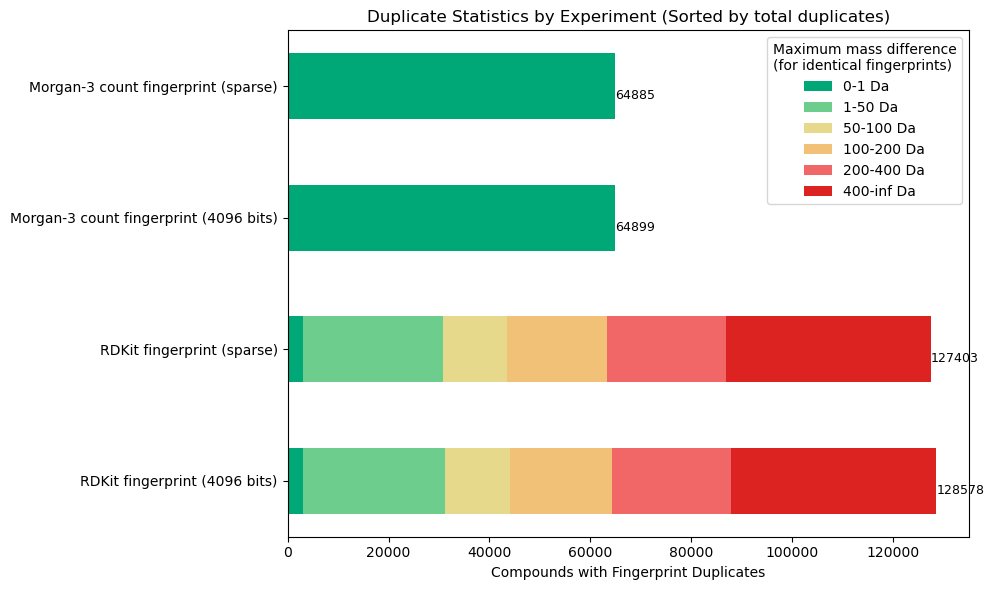

In [151]:
# Define the bins
bins = [(0, 1), (1, 50), (50, 100), (100, 200), (200, 400), (400, np.inf)]
bin_labels = [f"{low}-{high} Da" if high != np.inf else f"{low}-inf Da" for low, high in bins]


# Initialize results storage
experiment_sums = {name: np.zeros(len(bins)) for _, name in files_experiments}

# Process each experiment
for file, name in files_experiments:
    # Load duplicates data
    with open(os.path.join(path_data, f"{file}_duplicates.pickle"), "rb") as f:
        duplicates = pickle.load(f)

    # Calculate statistics
    duplicate_statistics = np.array([len(x) for x in duplicates])
    duplicate_masses = [masses[i] for i in duplicates]
    max_mass_differences = np.concatenate([compute_compound_max_differences(x) for x in duplicate_masses])

    # Compute sums for each bin
    for i, (low, high) in enumerate(bins):
        idx = np.where((max_mass_differences >= low) & (max_mass_differences < high))[0]
        experiment_sums[name][i] = idx.shape[0]

# Sort experiments by total sum
sorted_experiments = sorted(
    experiment_sums.items(), 
    key=lambda item: item[1].sum(), 
    reverse=True
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare for stacked bar chart
width = 0.5
y_positions = np.arange(len(sorted_experiments))
left_stack = np.zeros(len(sorted_experiments))

# Iterate over bins and stack their sums
for i, label in enumerate(bin_labels):
    values = [experiment[1][i] for experiment in sorted_experiments]
    ax.barh(y_positions, values, width, label=label, left=left_stack, color=colors[i])
    left_stack += values

# Add numbers
for i, y in enumerate(y_positions):
    value = sorted_experiments[i][1].sum()
    plt.text(value, i-0.1, f"{value:.0f}", fontsize=9)

# Configure plot appearance
ax.set_yticks(y_positions)
ax.set_yticklabels([experiment[0] for experiment in sorted_experiments])
ax.set_xlabel("Compounds with Fingerprint Duplicates")
ax.set_title("Duplicate Statistics by Experiment (Sorted by total duplicates)")
ax.legend(title="Maximum mass difference\n(for identical fingerprints)", loc="upper right")

plt.tight_layout()
plt.savefig("Duplicate_statistics_max_mass_difference_700k_sparse.pdf")
plt.savefig("Duplicate_statistics_max_mass_difference_700k_sparse.png", dpi=300)
plt.show()
